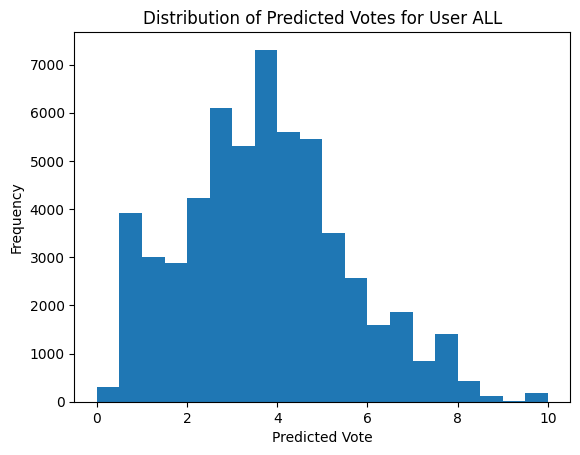

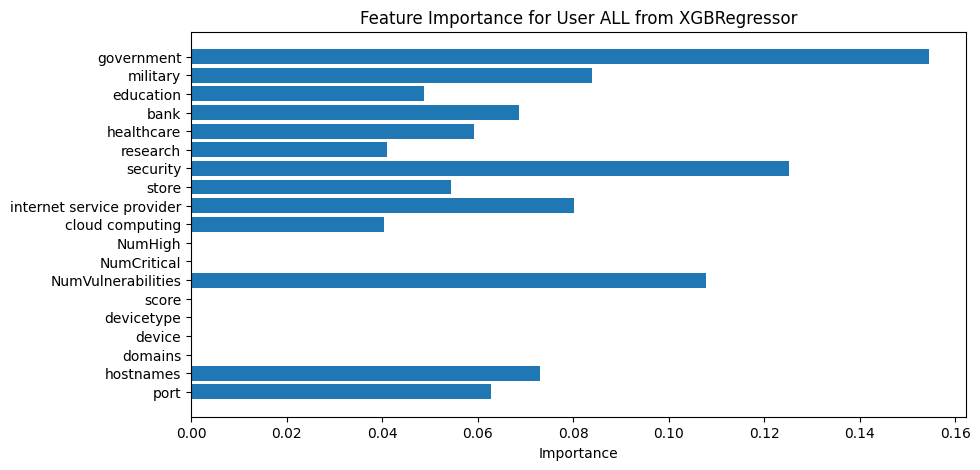

                       meta_id                         timestamp  \
0   01J18XRAQMM5BPR9DQX9XDZCH2  2024-06-26 00:05:01.812494+00:00   
1   01J18YM6W000QGYH6WA701FPGC  2024-06-26 00:20:15.360307+00:00   
2   01J18YM6W000QGYH6WA701FPGC  2024-06-26 00:20:15.360307+00:00   
3   01J18YM6W000QGYH6WA701FPGC  2024-06-26 00:20:15.360307+00:00   
4   01J18YQMCJ1QRJP345XV1X3XYK  2024-06-26 00:22:07.506616+00:00   
5   01J190D9N95DCT36RCWW6CMSBQ  2024-06-26 00:51:25.993327+00:00   
6   01J190D9N95DCT36RCWW6CMSBQ  2024-06-26 00:51:25.993327+00:00   
7   01J190Q29GH897MJ9TV3NT2A45  2024-06-26 00:56:46.128369+00:00   
8   01J190SPFMH5HYNJKKH5N84M84  2024-06-26 00:58:12.340519+00:00   
9   01J19166FS4HGXF9HQHCFTAADV  2024-06-26 01:05:01.945805+00:00   
10  01J19166FS4HGXF9HQHCFTAADV  2024-06-26 01:05:01.945805+00:00   
11  01J19166FS4HGXF9HQHCFTAADV  2024-06-26 01:05:01.945805+00:00   
12  01J19166FS4HGXF9HQHCFTAADV  2024-06-26 01:05:01.945805+00:00   
13  01J19166FS4HGXF9HQHCFTAADV  2024-06-26 01:05

In [23]:
for user in merged_table_all["username"].unique():
    filtered_table = merged_table[merged_table["username"] == user]

    training_features = filtered_table.apply(lambda row: extract_features(row, include_vote=True), axis=1)
    training_df = pd.DataFrame(training_features.tolist())

    for col in ["device", "devicetype"]:
        training_df[col] = training_df[col].astype("category").cat.codes

    X_train = training_df.drop(columns=["Vote"], errors='ignore')
    y_train = training_df["Vote"]
    
    model = XGBRegressor(n_estimators=100000, learning_rate=0.1, max_depth=30, verbosity=0, random_state=70)
    model.fit(X_train, y_train)
    
    new_features = sampled_data.apply(lambda row: extract_features(row, include_vote=False), axis=1)
    new_features_df = pd.DataFrame(new_features.tolist())
    
    for col in ["device", "devicetype"]:
        new_features_df[col] = new_features_df[col].astype("category").cat.codes
    
    predictions = model.predict(new_features_df)
    sampled_data[f'predicted_vote_{user}'] = predictions
    
    plt.hist(predictions, bins=20)
    plt.xlabel("Predicted Vote")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Predicted Votes for User {user}")
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.barh(X_train.columns, model.feature_importances_)
    plt.xlabel("Importance")
    plt.title(f"Feature Importance for User {user} from XGBRegressor")
    plt.show()

print(sampled_data.head(20))

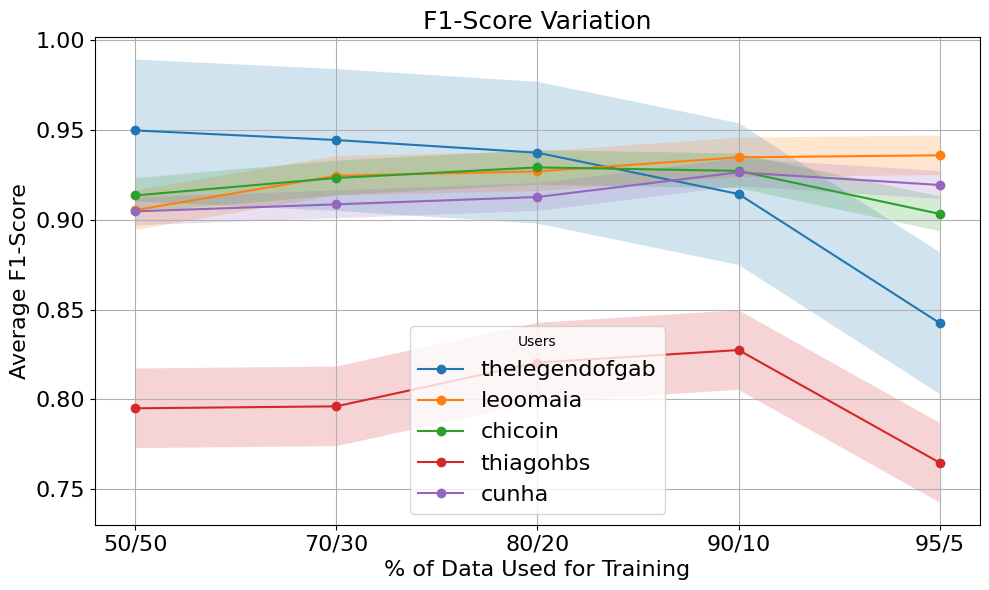

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from xgboost import XGBRegressor

# Adjust to your dataset structure
def extract_features(row):
    org_types = ["cloud computing", "internet service provider", "store", "security", 
                 "research", "healthcare", "bank", "education", "military", "government"]
    
    org_type_features = {org_type: row.get(org_type, 0) for org_type in org_types}
    
    features = {
        "user_id": row["user_id"],
        "ip_str": row["ip_str"],
        "port": row["port_x"],
        "hostnames": len(row["hostnames"].split(",")) if pd.notna(row["hostnames"]) else 0,
        "domains": len(row["domains"].split(",")) if pd.notna(row["domains"]) else 0,
        "device": row["device"],
        "devicetype": row["devicetype"],
        "vulns": len(row["vulns"].split(",")) if pd.notna(row["vulns"]) else 0,
        "user_name": row["username"],
        "Vote": int(row["vote"]),
    }

    features.update(org_type_features)
    return features

features = merged_table.apply(extract_features, axis=1)
features_df = pd.DataFrame(features.tolist())

splits = [0.5, 0.7, 0.8, 0.9, 0.95]
average_f1_dict = {split: [] for split in splits}
unique_users = features_df['user_name'].unique()

for split in splits:
    for user in unique_users:
        user_f1_scores = []
        user_data = features_df[features_df['user_name'] == user]
        if len(user_data) < 2:
            continue

        for iteration in range(5): 
            seed = iteration + 78
            X = user_data.drop(columns=["ip_str", "user_name", "Vote"])  # Features
            y = user_data["Vote"]  # Target
            
            y_binary = (y >= y.median()).astype(int) 
            
            X_train, X_test, y_train, y_test = train_test_split(
                X, y_binary, test_size=(1 - split), random_state=seed, shuffle=True
            )

            model = XGBRegressor(n_estimators=10000, learning_rate=0.1, max_depth=20, 
                                 verbosity=0, enable_categorical=True, random_state=seed)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            y_pred_binary = (y_pred >= 0.5).astype(int)
            f1 = f1_score(y_test, y_pred_binary)
            user_f1_scores.append(f1)

        average_f1_dict[split].append(np.mean(user_f1_scores))

plt.figure(figsize=(10, 6))
x_positions = np.arange(len(splits))
user_f1_dict = {user: [] for user in features_df['user_name'].unique() if user != "admin"}
user_vote_counts = features_df['user_name'].value_counts().to_dict()

for split_index, (split, avg_f1_list) in enumerate(average_f1_dict.items()):
    for i, f1 in enumerate(avg_f1_list):
        user_name = features_df['user_name'].unique()[i]
        if user_name == "admin":
            continue
        user_f1_dict[user_name].append(f1)

for user, f1_values in user_f1_dict.items():
    if len(f1_values) == len(x_positions):
        avg_f1 = np.mean(f1_values)
        std_dev = np.std(f1_values)
        plt.plot(x_positions, f1_values, linestyle='-', marker='o', label=f"{user}")
        plt.fill_between(x_positions, np.array(f1_values) - std_dev, np.array(f1_values) + std_dev, alpha=0.2)

plt.xticks(x_positions, ['50/50', '70/30', '80/20', '90/10', '95/5'], fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('% of Data Used for Training', fontsize=16)
plt.ylabel('Average F1-Score', fontsize=16)
plt.title('F1-Score Variation', fontsize=18)
plt.legend(fontsize=16, title="Users")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

def extract_features(row):
    org_types = [
        "cloud computing", "internet service provider", "store", "security", 
        "research", "healthcare", "bank", "education", "military", "government"
    ]
    
    org_type_features = {org_type: row.get(org_type, 0) for org_type in org_types}
    
    features = {
        "user_id": row["user_id"],
        "ip_str": row["ip_str"],
        "port": row["port_x"],
        "hostnames": len(row["hostnames"].split(",")) if pd.notna(row["hostnames"]) else 0,
        "domains": len(row["domains"].split(",")) if pd.notna(row["domains"]) else 0,
        "device": row["device"],
        "devicetype": row["devicetype"],
        "vulns_count": len(row["vulns"].split(",")) if pd.notna(row["vulns"]) else 0,
        "vulns_scores": row["vulns_scores"],
        "vote": int(row["vote"]),
        "username": row["username"]
    }
    
    features.update(org_type_features)
    
    return features

features = merged_table.apply(extract_features, axis=1)
features_df = pd.DataFrame(features.tolist())

param_dist = {
    'n_estimators': [100, 300, 500, 700],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
}

split = 0.8
user_rmse_dict = {}
user_vote_counts = features_df['username'].value_counts().to_dict()

for user in features_df['username'].unique():
    if user == "thelegendofgab":
        continue  # Skip this user

    user_data = features_df[features_df['username'] == user]
    if len(user_data) < 2:
        print(f"Skipping user: {user} due to insufficient data.")
        continue

    user_accuracies = []
    for iteration in range(5): 
        seed = iteration + 33

        X = user_data.drop(columns=["ip_str", "vulns_scores", "username", "vote"])
        y = user_data["vote"]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=(1 - split), random_state=seed, shuffle=True
        )

        model = XGBRegressor(enable_categorical=True, random_state=seed)

        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_dist,
            n_iter=10,
            scoring='neg_mean_squared_error',
            cv=2,
            random_state=seed,
            n_jobs=-1
        )

        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_
        y_pred = best_model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        user_accuracies.append(rmse)

    user_rmse_dict[user] = user_accuracies

user_avg_rmse = {user: np.mean(rmses) for user, rmses in user_rmse_dict.items()}
user_std_rmse = {user: np.std(rmses) for user, rmses in user_rmse_dict.items()}

plt.figure(figsize=(12, 8))
users = list(user_avg_rmse.keys())
avg_rmses = list(user_avg_rmse.values())
std_devs = list(user_std_rmse.values())

plt.bar(users, avg_rmses, yerr=std_devs, capsize=5, color='skyblue', edgecolor='black')
plt.xlabel("User", fontsize=15)
plt.ylabel("Average RMSE", fontsize=15)
plt.title("Average RMSE per User with Error Bars", fontsize=18)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.figure(figsize=(10, 6))
all_rmse_values = [rmse for rmses in user_rmse_dict.values() for rmse in rmses]
plt.boxplot(all_rmse_values, vert=False, patch_artist=True)
plt.xlabel("RMSE", fontsize=15)
plt.title("RMSE Distribution Across All Users", fontsize=18)
plt.tight_layout()

plt.show()


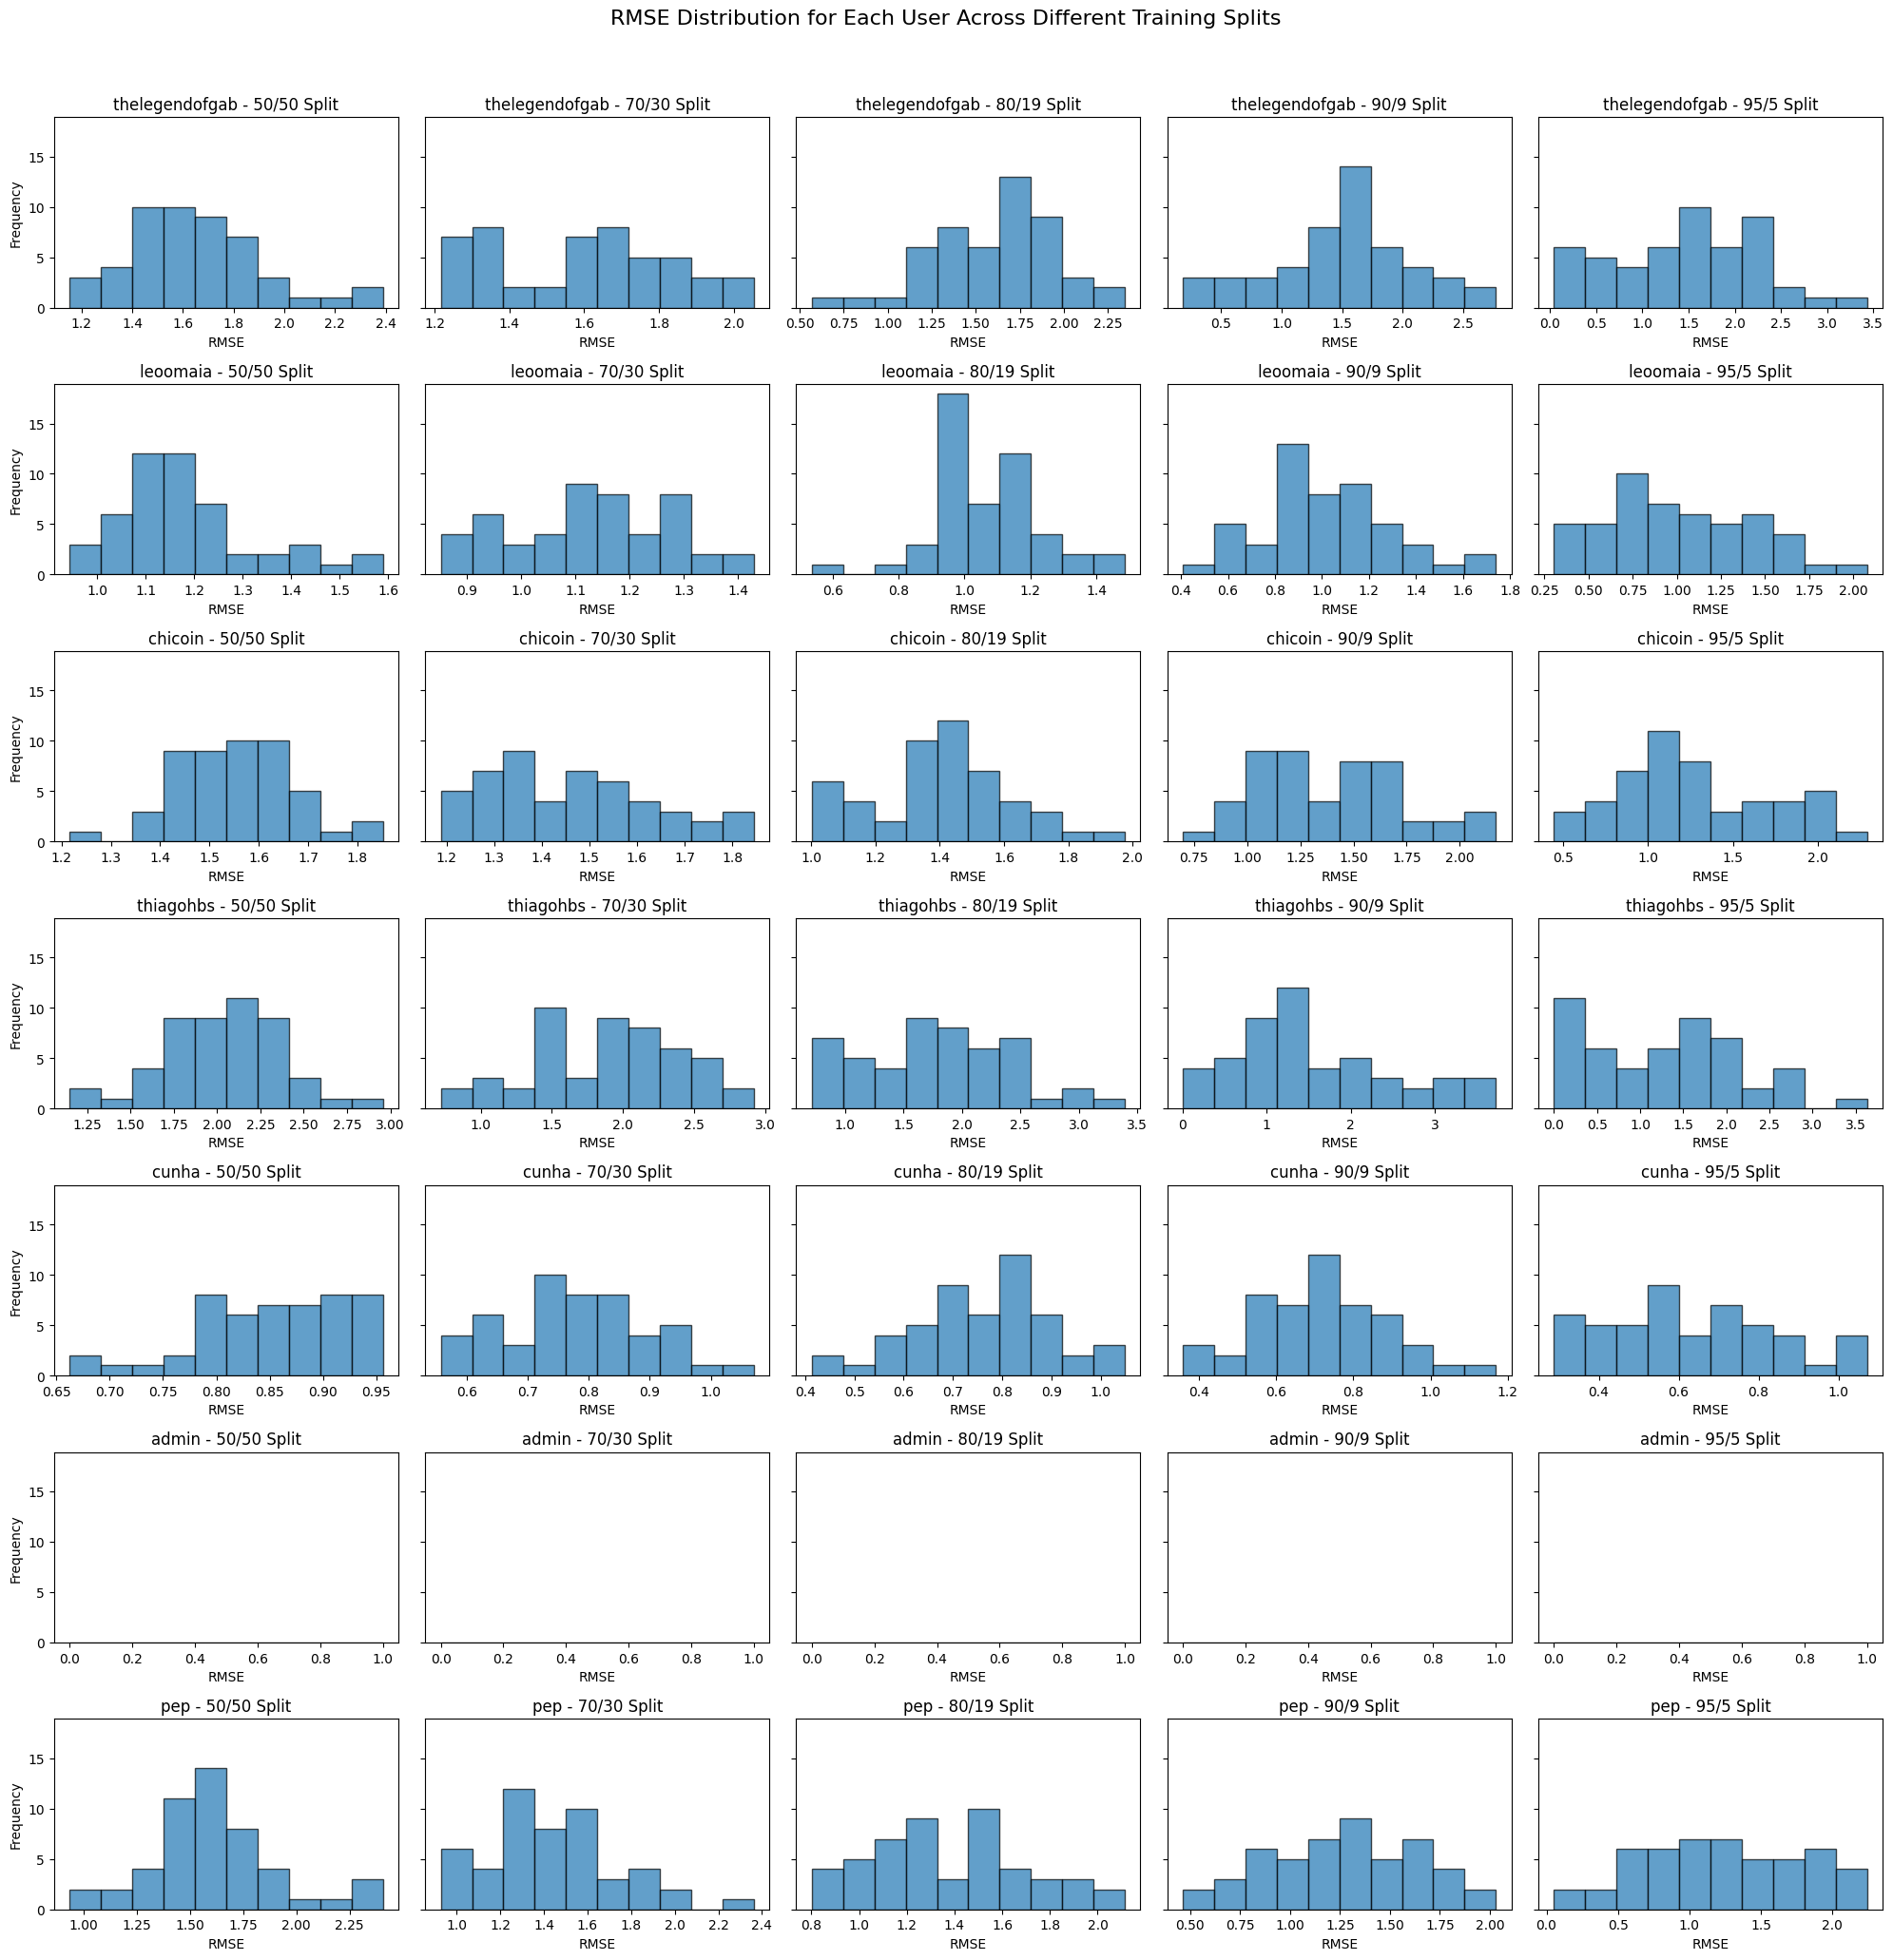

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

def extract_features(row):
    org_types = ["cloud computing", "internet service provider", "store", "security", 
                 "research", "healthcare", "bank", "education", "military", "government"]

    org_type_features = {org_type: row.get(org_type, 0) for org_type in org_types}
    
    features = {
        "user_id": row["user_id"],
        "ip_str": row["ip_str"],
        "port": row["port_x"],
        "hostnames": len(row["hostnames"].split(",")) if pd.notna(row["hostnames"]) else 0,
        "domains": len(row["domains"].split(",")) if pd.notna(row["domains"]) else 0,
        "device": row["device"],
        "devicetype": row["devicetype"],
        "vulns": len(row["vulns"].split(",")) if pd.notna(row["vulns"]) else 0,
        "user_name": row["username"],
        "Vote": int(row["vote"]),
    }

    features.update(org_type_features)
    return features

features = merged_table.apply(extract_features, axis=1)
features_df = pd.DataFrame(features.tolist())

splits = [0.5, 0.7, 0.8, 0.9, 0.95]
user_rmse_dict = {user: {split: [] for split in splits} for user in features_df['user_name'].unique()}

for split in splits:
    for user in user_rmse_dict.keys():
        user_data = features_df[features_df['user_name'] == user]
        if len(user_data) < 2:
            continue

        for iteration in range(50): 
            seed = iteration + 1200 
            X = user_data.drop(columns=["ip_str", "user_name", "Vote"])  # Features
            y = user_data["Vote"]  # Target

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=(1 - split), random_state=seed, shuffle=True
            )

            model = XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=15, 
                                 verbosity=0, enable_categorical=True, random_state=seed)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            user_rmse_dict[user][split].append(rmse)

n_users = len(user_rmse_dict)
fig, axes = plt.subplots(n_users, len(splits), figsize=(20, n_users * 3), sharey=True)
fig.suptitle("RMSE Distribution for Each User Across Different Training Splits", fontsize=16)

for user_idx, (user, split_data) in enumerate(user_rmse_dict.items()):
    for split_idx, (split, rmse_values) in enumerate(split_data.items()):
        ax = axes[user_idx, split_idx] if n_users > 1 else axes[split_idx]
        ax.hist(rmse_values, bins=10, edgecolor='black', alpha=0.7)
        ax.set_title(f"{user} - {int(split * 100)}/{int((1 - split) * 100)} Split")
        ax.set_xlabel("RMSE")
        if split_idx == 0:
            ax.set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()


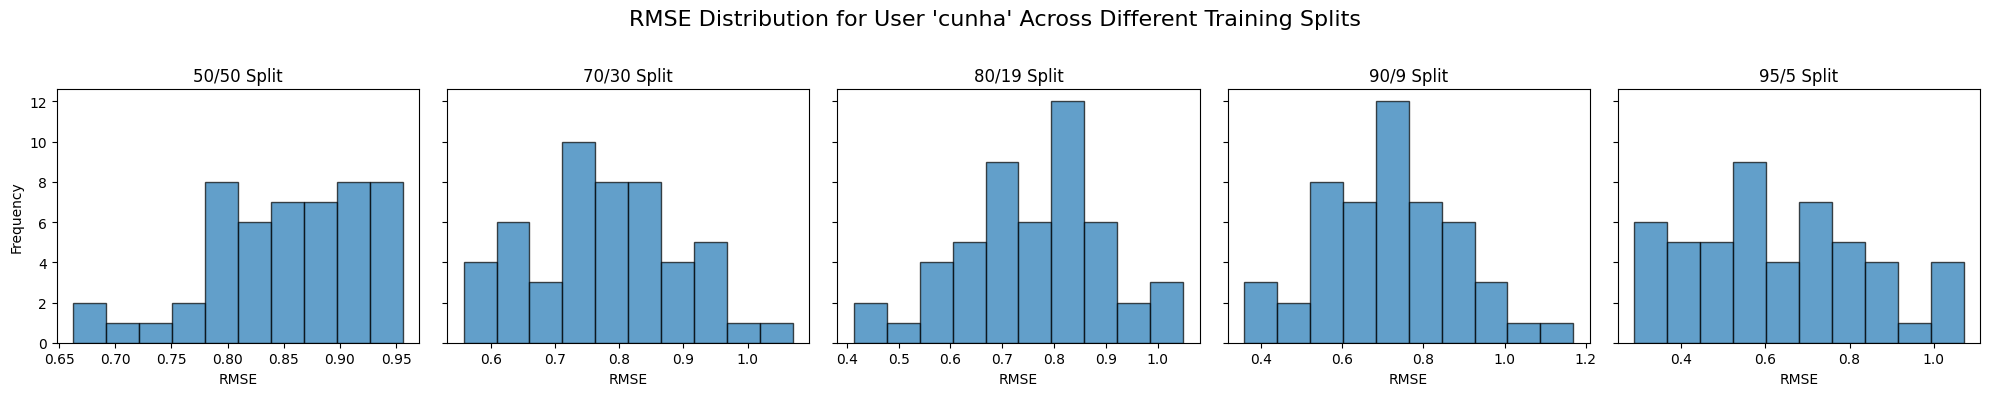

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

def extract_features(row):
    org_types = ["cloud computing", "internet service provider", "store", "security", 
                 "research", "healthcare", "bank", "education", "military", "government"]

    org_type_features = {org_type: row.get(org_type, 0) for org_type in org_types}
    
    features = {
        "user_id": row["user_id"],
        "ip_str": row["ip_str"],
        "port": row["port_x"],
        "hostnames": len(row["hostnames"].split(",")) if pd.notna(row["hostnames"]) else 0,
        "domains": len(row["domains"].split(",")) if pd.notna(row["domains"]) else 0,
        "device": row["device"],
        "devicetype": row["devicetype"],
        "vulns": len(row["vulns"].split(",")) if pd.notna(row["vulns"]) else 0,
        "user_name": row["username"],
        "Vote": int(row["vote"]),
    }

    features.update(org_type_features)
    return features

features = merged_table.apply(extract_features, axis=1)
features_df = pd.DataFrame(features.tolist())

features_df = features_df[features_df['user_name'] == 'cunha']

splits = [0.5, 0.7, 0.8, 0.9, 0.95]
user_rmse_dict = {split: [] for split in splits}

for split in splits:
    user_data = features_df
    if len(user_data) < 2:
        continue

    for iteration in range(50): 
        seed = iteration + 1200 
        X = user_data.drop(columns=["ip_str", "user_name", "Vote"])  # Features
        y = user_data["Vote"]  # Target

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=(1 - split), random_state=seed, shuffle=True
        )

        model = XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=15, 
                             verbosity=0, enable_categorical=True, random_state=seed)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        user_rmse_dict[split].append(rmse)

fig, axes = plt.subplots(1, len(splits), figsize=(20, 4), sharey=True)
fig.suptitle("RMSE Distribution for User 'cunha' Across Different Training Splits", fontsize=16)

for split_idx, (split, rmse_values) in enumerate(user_rmse_dict.items()):
    ax = axes[split_idx] if len(splits) > 1 else axes
    ax.hist(rmse_values, bins=10, edgecolor='black', alpha=0.7)
    ax.set_title(f"{int(split * 100)}/{int((1 - split) * 100)} Split")
    ax.set_xlabel("RMSE")
    if split_idx == 0:
        ax.set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()
